In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, radon, iradon

In [2]:
def add_QUBO(position, values, sinogram_values):
    linear = np.square(values)
    tmp1 = values*np.transpose(values)
    tmp2 = np.ones(np.size(position)) - np.eye(np.size(position))
    tmp3 = linear - 2*sinogram_values*values
    return np.triu(2*np.multiply(tmp1,tmp2) + np.diag(tmp3.flatten()))

In [3]:
def Q_mat(qubits,QM):
    max_d = format(len(str(qubits)), '02')
    
    # linear terms
    Q = {}
    for i in range(qubits):
        linear_term = format(i + 1, max_d)
        exec("Q.update({('q%s','q%s'):%s})"%(linear_term, linear_term, format(QM[i][i])))
    
    # quadratic terms
    for i in range(qubits-1):
        for j in range(i+1,qubits):
            if QM[i][j] != 0:
                qdrt1 = format(i + 1, max_d)
                qdrt2 = format(j + 1, max_d)
                exec("Q.update({('q%s','q%s'):%s})"%(qdrt1,qdrt2,format(QM[i][j])))
    return Q


## Quantum supremacy: Limited projection angle

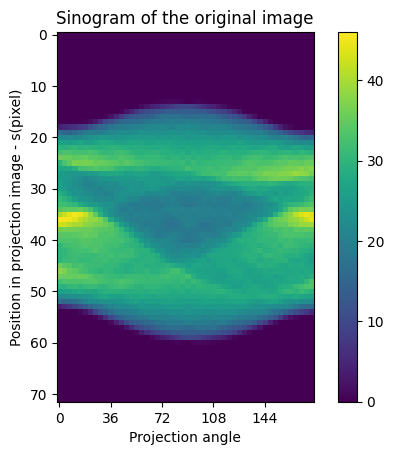

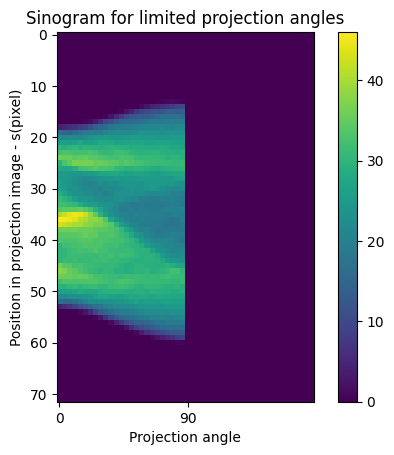

In [4]:
num_qb = 1
nx = 50
pad = 11
phantom = shepp_logan_phantom() # 400 x 400
phantom = rescale(phantom, nx/400) 
sol_phantom = phantom
phantom = np.pad(phantom, ((pad,pad),(pad,pad)))

dtheta = 180/nx
max_angle = 180
tnp = max_angle/(dtheta)
theta50 = np.arange(0, 180, dtheta)
theta25 = theta50[0:25]

rs_phantom = phantom/np.max(phantom)*(pow(2,num_qb)-1)
rs_phantom[rs_phantom>0.2]=1.0
rs_phantom[rs_phantom<=0.2] = 0.0
fn_phantom = np.round(rs_phantom, 0) 
sino50 = radon(fn_phantom, theta50)
sino25 = radon(fn_phantom, theta25)


plt.figure()
plt.title("Sinogram of the original image")
fig = plt.imshow(sino50)
plt.xticks(ticks=[0, 10, 20, 30, 40], labels=['0', '36', '72', '108', '144'])
plt.xlabel("Projection angle")
plt.ylabel("Position in projection image - s(pixel)")
plt.colorbar() 
plt.show()


sino25_zeros = np.concatenate((sino25,np.zeros((72,25))),axis=1)
plt.figure()
plt.title("Sinogram for limited projection angles")
fig = plt.imshow(sino25_zeros)
plt.xticks(ticks=[0, 25], labels=['0', '90'])
plt.xlabel("Projection angle")
plt.ylabel("Position in projection image - s(pixel)")
plt.colorbar() 
plt.show()

In [5]:
QM = np.zeros((num_qb*nx**2,num_qb*nx**2))
Fin_Min = 0
num_row = num_qb*nx
for sino_ny in range(0,int(len(theta25))):
    temp_theta = [theta25[sino_ny]]
    for sino_nx in range(0,nx+2*pad): 
        Arr_pos = np.array([])
        Arr_val = np.array([])
        for j in range(0,nx):
            for i in range(0,nx):
                G = np.zeros((nx+2*pad,nx+2*pad))
                G[i+pad][j+pad] = 1
                R = radon(G, temp_theta)
                for qb in range(0, num_qb):
                    Arr_pos = np.append(Arr_pos, np.array(i+num_row*(j)))
                    Arr_val = np.append(Arr_val, np.array(R[sino_nx][0]))
        sino_val = sino50[sino_nx][sino_ny]
        QM = QM + add_QUBO(Arr_pos.reshape(-1,1), Arr_val.reshape(-1,1), sino_val)
        Fin_Min -= sino_val**2

In [6]:

# # Transform the QM matrix into a dictionary format for D-Wave input
Q = Q_mat(num_qb*nx*nx, QM)

# # Use D-Wave's Leap Hybrid Sampler to solve the QUBO problem
# # The sampler runs a hybrid quantum-classical algorithm to find an optimal solution
# # 'answer' contains the sampled results from the quantum annealer
from dwave.system import LeapHybridSampler

sampler = LeapHybridSampler()
answer = sampler.sample_qubo(Q)

print(answer,'\n')

print('Target minimum energy = ', Fin_Min)
print("Our minimum energy = ", answer.record[0][1])

  q0001 q0002 q0003 q0004 q0005 q0006 q0007 ... q2500          energy num_oc.
0     0     0     0     0     0     0     0 ...     0 -716219.004166       1
[BINARY, 1 rows, 1 samples, 2500 variables]

Target minimum energy =  -716219.0041665074
Our minimum energy =  -716219.0041665088


MAE Comparison: Our Method vs. Original Image & FFT Result vs. Original Image
MAE for hybrid solver =  0.0
MAE for FFT =  0.37162027962659266


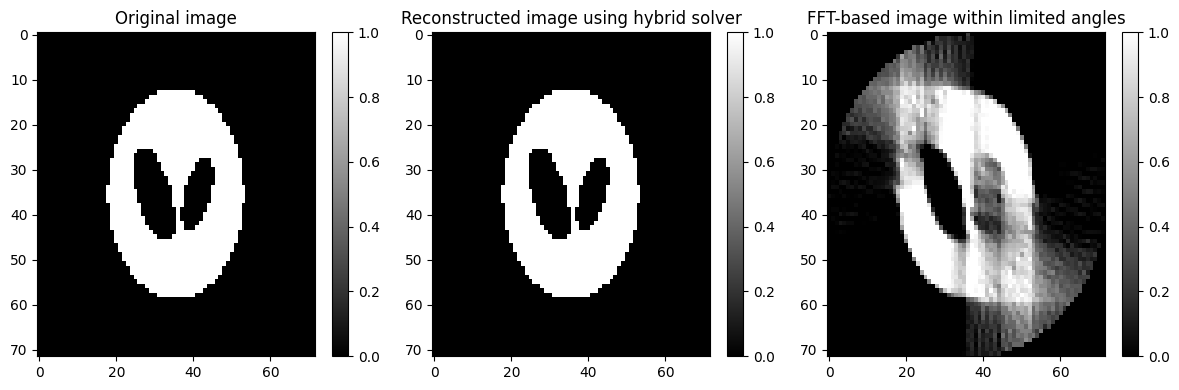

In [7]:
# Reconstructed image using the proposed method and hybrid solver 
data = answer.record[0][0]  

CT_phantom = np.zeros((nx,nx))
for j in range(0,nx):
    for i in range(0,nx):
        for k in range(0,num_qb):
            CT_phantom[i][j] = CT_phantom[i][j] + data[i*num_qb + j*num_qb*nx + k]
            
CT_phantom = np.pad(CT_phantom, ((pad,pad),(pad,pad)))

# Reconstructed image using FFT within limited projection angles
fft_image = iradon(sino25,theta25)

print("MAE Comparison: Our Method vs. Original Image & FFT Result vs. Original Image")
print("MAE for hybrid solver = ", np.mean(np.abs(fn_phantom[pad:nx+pad,pad:nx+pad] - CT_phantom[pad:nx+pad,pad:nx+pad])))
print("MAE for FFT = ",np.mean(np.abs(fn_phantom[pad:nx+pad,pad:nx+pad] - fft_image[pad:nx+pad,pad:nx+pad])))

# Comparison of Reconstruction Results
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.title('Original image')
plt.imshow(fn_phantom, cmap='gray', aspect='auto')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Reconstructed image using hybrid solver")
plt.imshow(CT_phantom, cmap='gray', aspect='auto')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("FFT-based image within limited angles")
plt.imshow(fft_image, cmap='gray', aspect='auto',vmin=0,vmax=num_qb)
plt.colorbar()

plt.tight_layout()
plt.show()

